# Robot Degradation Simulation
The goal of this python notebook is to accurately model a real robot and add degradations to it. The UR5e pictured below is an open-chain robot defined by two links, and two revolute joints operated in 2-space. The robot is under the influence of gravity and is controlled using torques at each joint. (The image doesn't render perfectly in this notebook, open in a browser)

![Alt text](./img/drawing.svg)

# Control
An LQR controller with gravity compensator is used to control the position of the robot. A typical linear time-invariant state-space system is pictured below. `x` are the system states, namely angular position and speed of the two joints. Similarly, `u` are the system inputs, torques added at each joint. `A`, `B`, and `C` are parameters that describe the system. Here, `K` are gains computed from LQR and `Nbar` are gains computed to bring the response to a desired steady state. `r` are the desired states where the angular speeds must be zero to satisfy controllability of the system. Lastly, In order to handle the non-linear dynamics of gravity on the robot, it is initially modelled without gravity to compute `K` terms. Then a gravity compensator is added, feed forward, to the system input: `u=-K*x+Nbar*r+g(x)`

![controller](./img/statefeedback_w_pre_motors.png)

# Simulation
The system is integrated using the *LSODA* method from scipy. This switches between two solver methods to better handle stiff ODEs. ODE solvers typically do not handle changing parameters and stochasisty well because of their inbuilt assumptions to improve accuracy and speed. To solve this, the simulation is broken into "chunks" where the current chunk's initial conditions are the final conditions of the previous chunk (see figure below with three chunks). In this way, we are able to change parameters between chunks.

![chunks](./img/3chunks.png)

In the figure, `theta1` and `omega1` are the shoulder angle and speed, while `theta2` and `omega2` are the elbow angle and speed. The simulation switches between two desired states each chunk: shoulder {30,45} elbow {45,90}.

# Degradation
The robot's joints degrade over time using a viscous friction model where a torque proportional to the speed is added in the opposite direction: `T=degradation*-omega` with units `Nm*s/m`. Additionally, degradation increases over time (but is constant each chunk): `current_degradation = current_chunk * chunk_time * (degradation_rate + N(0,SD))`.

Some further degradations could be dependent on current position, stiction, etc.

In [61]:
from __future__ import print_function, division
from sympy import symbols, simplify, pi, lambdify
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point
from sympy.physics.vector import init_vprinting
from pydy.system import System
import numpy as np
init_vprinting(use_latex='mathjax', pretty_print=False)


# Reference Frames

In [62]:
inertial_frame = ReferenceFrame('I')
upper_arm_frame = ReferenceFrame('U')
fore_arm_frame = ReferenceFrame('F')
# theta1 - shoulder, theta2 - elbow
theta1, theta2 = dynamicsymbols('theta1, theta2')


In [63]:
upper_arm_frame.orient(inertial_frame, 'Axis', (theta1, inertial_frame.z))
fore_arm_frame.orient(upper_arm_frame, 'Axis', (theta2, upper_arm_frame.z))

# Points

In [64]:
# Joints
shoulder = Point('S')
upper_arm_length = symbols('l_U')

elbow = Point('E')
elbow.set_pos(shoulder, upper_arm_length * upper_arm_frame.y)

end_effector = Point('EE')
fore_arm_length = symbols('l_F')
end_effector.set_pos(elbow, fore_arm_length * fore_arm_frame.y)
end_effector.pos_from(shoulder)


l_U*U.y + l_F*F.y

In [65]:
# Center of Masses
upper_arm_com_length, fore_arm_com_length = symbols('d_U, d_F')

upper_arm_mass_center = Point('U_o')
upper_arm_mass_center.set_pos(shoulder, upper_arm_com_length * upper_arm_frame.y)

fore_arm_mass_center = Point('F_o')
fore_arm_mass_center.set_pos(elbow, fore_arm_com_length * fore_arm_frame.y)
fore_arm_mass_center.pos_from(shoulder)


l_U*U.y + d_F*F.y

# Kinematical Differential Equations

In [66]:
# the generalized speeds are the angular velocities of the joints
omega1, omega2 = dynamicsymbols('omega1, omega2')

kinematical_differential_equations = [omega1 - theta1.diff(),
                                      omega2 - theta2.diff()]
kinematical_differential_equations


[omega1 - theta1', omega2 - theta2']

# Velocities

In [67]:
upper_arm_frame.set_ang_vel(inertial_frame, omega1 * inertial_frame.z)
fore_arm_frame.set_ang_vel(upper_arm_frame, omega2 * upper_arm_frame.z)
fore_arm_frame.ang_vel_in(inertial_frame)


omega1*I.z + omega2*U.z

In [68]:
shoulder.set_vel(inertial_frame, 0)
upper_arm_mass_center.v2pt_theory(shoulder, inertial_frame, upper_arm_frame)

elbow.v2pt_theory(shoulder, inertial_frame, upper_arm_frame)

fore_arm_mass_center.v2pt_theory(elbow, inertial_frame, fore_arm_frame)

end_effector.v2pt_theory(elbow, inertial_frame, fore_arm_frame)


- l_U*omega1*U.x - l_F*(omega1 + omega2)*F.x

# Inertia

In [69]:
from sympy.physics.mechanics import inertia, RigidBody

# Mass
upper_arm_mass, fore_arm_mass = symbols('m_U, m_F')

# Inertia
upper_arm_inertia, fore_arm_inertia = symbols('I_Uz, I_Fz')

upper_arm_inertia_dyadic = inertia(upper_arm_frame, 0, 0, upper_arm_inertia)

upper_arm_central_inertia = (upper_arm_inertia_dyadic, upper_arm_mass_center)

fore_arm_inertia_dyadic = inertia(fore_arm_frame, 0, 0, fore_arm_inertia)

fore_arm_central_inertia = (fore_arm_inertia_dyadic, fore_arm_mass_center)

# rigid bodies
upper_arm = RigidBody('Upper Arm', upper_arm_mass_center, upper_arm_frame,
                      upper_arm_mass, upper_arm_central_inertia)

fore_arm = RigidBody('Upper Leg', fore_arm_mass_center, fore_arm_frame,
                     fore_arm_mass, fore_arm_central_inertia)


# Kinetics

In [70]:
# gravity
g = symbols('g')
upper_arm_grav = (upper_arm_mass_center,-upper_arm_mass * g * inertial_frame.y)

fore_arm_grav = (fore_arm_mass_center,-fore_arm_mass * g * inertial_frame.y)

# square wave


In [71]:
# joint torques

shoulder_torque, elbow_torque = dynamicsymbols('T_s, T_e')

upper_arm_torque = (upper_arm_frame,
                    shoulder_torque * inertial_frame.z - elbow_torque *
                    inertial_frame.z)

fore_arm_torque = (fore_arm_frame,
                    elbow_torque * inertial_frame.z)


# Equations of Motion

In [72]:
from sympy.physics.mechanics import KanesMethod

coordinates = [theta1, theta2]

speeds = [omega1, omega2]

kane = KanesMethod(inertial_frame,
                   coordinates,
                   speeds,
                   kinematical_differential_equations)

loads = [
    # upper_arm_grav,
    # fore_arm_grav,
    upper_arm_torque,
    fore_arm_torque]

bodies = [upper_arm, fore_arm]

fr, frstar = kane.kanes_equations(bodies, loads)

mass_matrix = kane.mass_matrix_full
forcing_vector = kane.forcing_full


kane_sys = System(kane)

upper_arm_radius_constant = 0.054
upper_arm_mass_constant = 8.393
fore_arm_length_constant = 0.392  # todo quick hack
fore_arm_radius_constant = 0.060
fore_arm_mass_constant = 2.275

# https://github.com/ros-industrial/universal_robot/blob/kinetic-devel/ur_e_description/urdf/ur5e.urdf.xacro
kane_sys.constants = {
    upper_arm_length: 0.425,  # [m]
    upper_arm_com_length: 0.2125,  # [m]
    upper_arm_mass: 8.393,  # [kg]
    # [kg*m^2]
    upper_arm_inertia: 0.5 * upper_arm_mass_constant * upper_arm_radius_constant ** 2,
    # fore_arm_length: 0.392,  # [m]
    fore_arm_com_length: 0.11993,  # [m]
    fore_arm_mass: fore_arm_mass_constant,  # [kg]
    # [kg*m^2]
    fore_arm_inertia: 0.5 * fore_arm_mass_constant * fore_arm_radius_constant ** 2,
    # g: 9.806
}


In [73]:
kane_sys.constants

{I_Fz: 0.004095, I_Uz: 0.012236994, d_F: 0.11993, d_U: 0.2125, l_U: 0.425, m_F: 2.275, m_U: 8.393}

# Simulation

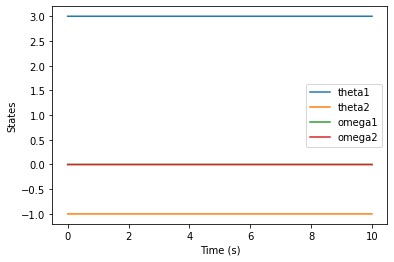

In [74]:
kane_sys.times = np.arange(0.0, 10.0, 0.005)
kane_sys.initial_conditions = {
                          theta1: 3.0,
                          theta2: -1.0,
                          omega1: 0.0,
                          omega2: 0.0,
                         }
states = kane_sys.integrate()


import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(kane_sys.times, states)
ax.set_ylabel('States')
ax.set_xlabel('Time (s)')
ax.legend(['theta1', 'theta2', 'omega1', 'omega2'])
plt.show()

In [75]:
from pydy.viz import Sphere, Cylinder, VisualizationFrame, Scene

shoulder_shape = Cylinder(
    name='shoulder', color='grey', radius=0.06, length=0.13)
elbow_shape = Cylinder(name='elbow', color='grey', radius=0.06, length=0.13)

shoulder_viz_frame = VisualizationFrame(
    'shoulder', inertial_frame.orientnew('side', 'Axis', (pi/2, inertial_frame.x)), shoulder, shoulder_shape)
elbow_viz_frame = VisualizationFrame(
    'elbow', inertial_frame.orientnew('side', 'Axis', (pi/2, inertial_frame.x)), elbow, elbow_shape)

upper_arm_center = Point('l_c')
fore_arm_center = Point('u_c')


upper_arm_center.set_pos(
    shoulder, kane_sys.constants[upper_arm_length]/2 * upper_arm_frame.y)
fore_arm_center.set_pos(elbow, fore_arm_length_constant/2 * fore_arm_frame.y)

upper_arm_shape = Cylinder(name='upper arm',
                        radius=upper_arm_radius_constant,
                        length=kane_sys.constants[upper_arm_length],
                        color='lightskyblue')

fore_arm_shape = Cylinder(name='fore arm',
                        radius=fore_arm_radius_constant,
                        length=fore_arm_length_constant,
                        color='lightskyblue')

upper_arm_viz_frame = VisualizationFrame('Upper Arm', upper_arm_frame,
                                        upper_arm_center, upper_arm_shape)

fore_arm_viz_frame = VisualizationFrame('Fore Arm', fore_arm_frame,
                                        fore_arm_center, fore_arm_shape)

scene = Scene(inertial_frame, shoulder, system=kane_sys)

scene.visualization_frames = [shoulder_viz_frame, elbow_viz_frame,
                            upper_arm_viz_frame, fore_arm_viz_frame]

# scene.display_jupyter()
    


# Open Loop

Text(0.5, 1.0, '1 Hz Square Wave')

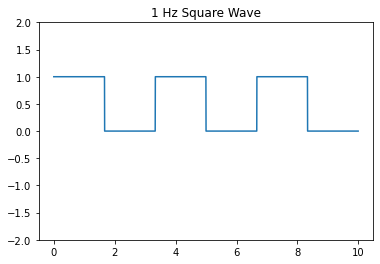

In [76]:
from scipy import signal, interpolate

import matplotlib.pyplot as plt

t = kane_sys.times
freq = 0.3  # Hz
amp = 1
center = 0.5
square_wave_data = center + (amp / 2) * signal.square(2 * np.pi * freq * t)
square_wave = interpolate.interp1d(t,square_wave_data, fill_value="extrapolate")

plt.plot(t, square_wave(t))

plt.ylim(-2, 2)
plt.title("1 Hz Square Wave")


Text(0, 0.5, 'angle (rad,rad/s)')

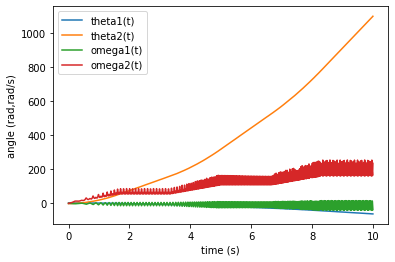

In [77]:
from scipy.integrate import odeint, solve_ivp

def controller(x, t):
    T_s = -square_wave(t)
    T_e = square_wave(t)
    return (T_s, T_e) #u The specified inputs are, in order: T_s(t), T_e(t)

y = odeint(kane_sys.generate_ode_function(), [3,-1,0,0], kane_sys.times, args=(controller,kane_sys.constants))

plt.plot(kane_sys.times,y)
plt.legend(kane_sys.states)
plt.xlabel('time (s)')
plt.ylabel('angle (rad,rad/s)')

In [78]:
scene = Scene(inertial_frame, shoulder)

scene.visualization_frames = [shoulder_viz_frame, elbow_viz_frame,
                            upper_arm_viz_frame, fore_arm_viz_frame]

scene.states_symbols = coordinates + speeds
scene.constants = kane_sys.constants
scene.states_trajectories = y
scene.times = kane_sys.times
# scene.display_jupyter()

# Controller Design

[[ 3.16227766e+01 -2.11773895e-12]
 [-2.95740752e-11  3.16227766e+01]]


array([7.85353776e-01, 1.57067832e+00, 4.34598184e-05, 1.17876521e-04])

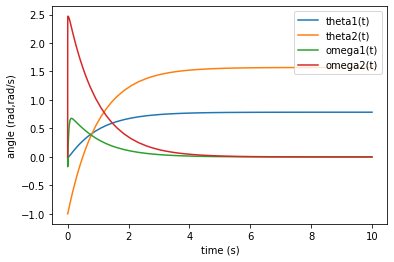

In [79]:
# https://github.com/pydy/pydy-tutorial-human-standing/blob/master/notebooks/solution/control.py
from numpy import zeros, ones, matrix, eye, dot, asarray, matmul
from numpy.linalg import inv
from scipy.linalg import solve_continuous_are

equilibrium_point = zeros(len(coordinates + speeds))
equilibrium_dict = dict(zip(coordinates + speeds, equilibrium_point))

linear_state_matrix, linear_input_matrix, inputs = \
    kane.linearize(new_method=True, A_and_B=True)
f_A_lin = linear_state_matrix.subs(kane_sys.constants).subs(equilibrium_dict)
f_B_lin = linear_input_matrix.subs(kane_sys.constants).subs(equilibrium_dict)
m_mat = mass_matrix.subs(kane_sys.constants).subs(equilibrium_dict)

A = np.array(m_mat.inv() * f_A_lin).astype(float)
B = np.array(m_mat.inv() * f_B_lin).astype(float)

Q = eye(4)*1000

R = eye(2)

S = solve_continuous_are(A, B, Q, R)

K = matmul(matmul(inv(R), np.transpose(B)), S)

# This is an annoying little issue. We specified the order of things when
# creating the rhs function, but the linearize function returns the F_B
# matrix in the order corresponding to whatever order it finds the joint
# torques. This would also screw things up if we specified a different
# ordering of the coordinates and speeds as the standard kane._q + kane._u

K = K[[1, 0], :]  # this is dumb haha

C = np.hstack((eye((f_B_lin.shape[1])), zeros(
    (f_B_lin.shape[1], f_B_lin.shape[1]))))

D = zeros((f_B_lin.shape[1], f_B_lin.shape[1]))

# N = (C(-A+BK)^-1 B)^-1
Nbar = inv(matmul(matmul(C, inv(-A+matmul(B, K))), B))

r = np.array([[float(pi/4.)], [float(pi/2.)]])  # two desired angles


def controller(x, t):
    u = asarray(np.add(-matmul(K, x).reshape(2, 1),
                matmul(Nbar, r).reshape(2, 1))).flatten()
    # u = -asarray(dot(K,x)).flatten()
    return u

sol = solve_ivp(lambda x, t, r, p: kane_sys.evaluate_ode_function(t, x, r, p),
                (kane_sys.times[0], kane_sys.times[-1]), [0, -1, 0, 0], method='LSODA', args=(controller, kane_sys.constants))

plt.plot(sol.t, np.transpose(sol.y))
plt.legend(kane_sys.states)
plt.xlabel('time (s)')
plt.ylabel('angle (rad,rad/s)')

In [80]:
scene = Scene(inertial_frame, shoulder)

scene.visualization_frames = [shoulder_viz_frame, elbow_viz_frame,
                              upper_arm_viz_frame, fore_arm_viz_frame]

scene.states_symbols = coordinates + speeds
scene.constants = kane_sys.constants
scene.states_trajectories = np.transpose(sol.y)
scene.times = sol.t
scene.display_jupyter()

In [81]:
# exponential degradation
# piecewise degradation modes
# torque joint limits
# 2 joints, 3 FM ea (100% 60% 30%)
# just the torque data
# can it lift the mass
# add some noise
# do with 5kg